# Circadian Detection Pipeline

In [331]:
import logging

import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)

import numpy as np
import pandas as pd

from importlib import reload

from memory import garbage_collect

log = lambda msg: logging.info(msg)


# Load data

In [332]:
from sleep_events import load_days_data

day_data = load_days_data(True)

In [333]:
%%capture

import circadian
reload(circadian)


first_day_with_data = '2024-07-14'
today = '2025-03-25'

all_days = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_with_data, today)]

all_raw_data = circadian.fetch_raw_data(day_data, all_days)


In [334]:
import circadian
reload(circadian)

all_processed = circadian.process_raw_data(all_raw_data)


c:\dev\Brainwave-Processor\notebooks\CircadianDetection\circadian.py:92: FutureWarning: The behavior of Series.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  local_valley_idx = window.idxmin()
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\pandas\core\generic.py:4106: RuntimeWarning: invalid value encountered in cast
  indices = np.asarray(indices, dtype=np.intp)


In [335]:
import sleep_events
reload(sleep_events)

import circadian
reload(circadian)

cr, cr_df = circadian.get_circadian_reviews()

Getting circadian rhythm reviews
Starting to process circadian rhythm reviews


In [417]:
[col for col in day_data.columns if 'night:aggregated:timeAwakeAfterSleepSecs' in col.lower()]







[]

In [427]:
day_data_insomniac_nights = day_data[day_data['night:aggregated:timeAwakeAfterSleepSecs'] > 60 * 60]
insomniac_nights = day_data_insomniac_nights['dayAndNightOf'].unique()


In [ ]:
first_day_with_data = min(all_processed.keys())
today = pd.Timestamp.now().strftime('%Y-%m-%d')
all_days = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_with_data, today)]
three_months_ago = (pd.Timestamp.now() - pd.Timedelta(days=90)).strftime('%Y-%m-%d')
last_3_months = [d.strftime('%Y-%m-%d') for d in pd.date_range(three_months_ago, today)]

all_processed_last_3_months = {
    day: data 
    for day, data in all_processed.items() 
    if day in last_3_months
}


In [431]:
all_processed_no_insomniac_nights = {
    day: data 
    for day, data in all_processed.items() 
    if day not in insomniac_nights
}
all_processed_insomniac_nights = {
    day: data 
    for day, data in all_processed.items() 
    if day in insomniac_nights
}

# Extracting & drawing features

In [336]:
joined_lep_df = None
joined_lt1_df = None
joined_mp1_df = None


In [494]:
def merge_all_types(exclude_insomniac_nights=True, verbose=False):
    out = []
    if joined_lep_df is not None:
        out.append(joined_lep_df)
    if joined_lt1_df is not None:
        out.append(joined_lt1_df)
    if joined_mp1_df is not None:
        out.append(joined_mp1_df)
                
    if len(out) == 0:
        if verbose:
            print("No data to merge")
        return None
    if len(out) == 1:
        if verbose:
            print("Only one type of data to merge")
        return out[0]
    
    # Merge all DataFrames in the list
    result = out[0]
    for df in out[1:]:
        result = pd.merge(result, df, on='dayAndNightOf', how='outer')
    
    # Detect types and create merged columns
    types = set()
    for col in result.columns:
        if col.endswith('_cr_datetime'):
            type_name = col.split('_cr_')[0]
            types.add(type_name)
    
    # Create merged columns for each type
    for type_name in types:
        # Datetime
        cr_datetime = f'{type_name}_cr_datetime'
        det_datetime = f'{type_name}_det_time'
        result[f'{type_name}_merge_datetime'] = result[cr_datetime].fillna(result[det_datetime])
        
        # Temperature
        cr_temp = f'{type_name}_cr_temp'
        det_temp = f'{type_name}_det_temp'
        result[f'{type_name}_merge_temp'] = result[cr_temp].fillna(result[det_temp])
        
        # Prominence (only exists in cr data)
        if f'{type_name}_cr_prominence' in result.columns:
            result[f'{type_name}_merge_prominence'] = result[f'{type_name}_cr_prominence']
    
    result['MP_To_LEP'] = result['LEP_cr_datetime'] - result['MP_cr_datetime']

    if exclude_insomniac_nights:
        result = result[~result['dayAndNightOf'].isin(insomniac_nights)]

    return result

merged = merge_all_types()
if merged is not None:
    merged.head()
else:
    print("No merged data") 

In [ ]:
merged

In [338]:
import circadian
reload(circadian)

post_lep_stats = circadian.calc_avg_mins_after_lep(all_processed, merge_all_types(), 2.5 * 60)
if post_lep_stats is not None:
    display(post_lep_stats.describe())
else:
    print("No post LEP stats")


No post LEP stats


In [339]:
import circadian
reload(circadian)


def do_it_all(day: str, start_time: str = '06:00:00Z', end_time: str = '12:00:00Z'):
    merged = merge_all_types()
    chart = circadian.do_it_all(day_data, day, start_time, end_time, merged, all_processed, post_lep_stats)
    display(chart)
    if merged is not None:
        vs_lep_avg = circadian.compare_night_to_average(all_processed, merged, post_lep_stats, day)
        display("Comparing to average period after LEP", vs_lep_avg)

do_it_all('2024-08-06', '19:00:00Z', '08:00:00Z') 

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'examined-life.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


alt.VConcatChart(...)

In [497]:
def debug_day(day):
    if day in insomniac_nights:
        print(f"Day {day} is an insomniac night")

    if all_processed.get(day) is None:
        print(f"No all_processed data for day {day}")
        return

    if 'df' in all_processed[day]:
        df = all_processed[day]['df']
        print(f"df has {len(df)} rows of temp data")
        print(df.describe())
    else:
        print(f"No df for day {day}")

    if 'dd' in all_processed[day]:
        dd = all_processed[day]['dd']
        if 'wakeTime' in dd.columns:
            wake_time = dd['wakeTime'].iloc[0]
            if pd.notna(wake_time):
                print(f"Wake time found for day {day}: {wake_time}")
            else:
                print(f"No wake time found for day {day}")
        else:
            print(f"No wake time found for day {day}")

        if 'asleepTime' in dd.columns:
            sleep_time = dd['asleepTime'].iloc[0]
            if pd.notna(sleep_time):
                print(f"Sleep time found for day {day}: {sleep_time}")
            else:
                print(f"No sleep time found for day {day}")
        else:
            print(f"No sleep time found for day {day}")
    else:
        print(f"No dd data for day {day} (probably need to do morning review)")  

    cr_df_day = cr_df[cr_df['dayAndNightOf'] == day]
    if cr_df_day.empty:
        print(f"No cr data for day {day} (probably need to do circadian review)")
    else:
        print(f"CR data for day {day}:")
        cols = [c for c in cr_df_day.columns if 'LEP_' in c or 'MP_' in c]
        display(cr_df_day[cols])


    joined_lep_df_day = joined_lep_df[joined_lep_df['dayAndNightOf'] == day]    
    if joined_lep_df_day is not None:
        print(f"LEP data in joined_lep_df_day:")  
        display(joined_lep_df_day)
    else:
        print(f"No LEP data in joined_lep_df_day")

    # joined_lt1_df_day = joined_lt1_df[joined_lt1_df['dayAndNightOf'] == day]
    # if joined_lt1_df_day is not None:
    #     print(f"LT1 data for day {day}:")
    #     display(joined_lt1_df_day)
    # else:
    #     print(f"No LT1 data in joined_lt1_df_day")

    joined_mp1_df_day = joined_mp1_df[joined_mp1_df['dayAndNightOf'] == day]
    if joined_mp1_df_day is not None:
        print(f"MP1 data for day {day}:")
        display(joined_mp1_df_day)
    else:
        print(f"No MP1 data in joined_mp1_df_day")

    merged_df = merge_all_types(verbose=True)
    if merged_df is None:
        print(f"No merged data at all yet")
        return
    else:
        merged_df_day = merged_df[merged_df['dayAndNightOf'] == day]
        if merged_df_day.empty:
            print(f"No merged data for day {day}")
            return
        else:
            lep_time = merged_df_day['LEP_cr_datetime'].iloc[0]
            if pd.isna(lep_time):
                print(f"No LEP time found for day {day}")
            else:
                print(f"LEP time found for day {day}: {lep_time}")

debug_day('2024-09-09')


Day 2024-09-09 is an insomniac night
df has 2161 rows of temp data
              Temp  Temp_Interpolated  Temp_Smoothed_Savgol
count  1418.000000        1490.000000           1461.000000
mean     36.745759          36.744372             36.747560
std       0.209162           0.207979              0.208370
min      36.230000          36.230000             36.230452
25%      36.597927          36.590000             36.597626
50%      36.830000          36.820000             36.832085
75%      36.891315          36.890000             36.894348
max      37.140000          37.140000             37.141746
Wake time found for day 2024-09-09: 2024-09-10 08:29:30+01:00
Sleep time found for day 2024-09-09: 2024-09-09 22:37:00+01:00
CR data for day 2024-09-09:


,LEP_status,LEP_temp,LEP_prominence,LEP_datetime
57,Selected,37.02,0.33,2024-09-09 20:20:00+00:00


LEP data in joined_lep_df_day:


,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,LEP_det_status,LEP_det_reason,LEP_det_time,LEP_det_temp,LEP_diff
57,2024-09-09,2024-09-09 21:20:00+01:00,37.02,0.33,Detected,Use 21:20 from ['21:20'] as it's closest to historical average of 22:06,2024-09-09 21:20:00+01:00,37.02,0 days


MP1 data for day 2024-09-09:


,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence,MP_det_status,MP_det_reason,MP_det_time,MP_det_temp,MP_diff
57,2024-09-09,2024-09-09 08:54:00+01:00,37.14,0.74,Detected,"Selected first stable peak at 08:51 from ['06:38', '08:51']",2024-09-09 08:51:00+01:00,37.14,0 days 00:03:00


No merged data for day 2024-09-09


In [461]:
day_data[day_data['dayAndNightOf'] == '2024-11-05']


,dayAndNightOf,date:daysSince,date:dayOfWeek,date:dayOfMonth,date:month,date:year,date:asStr,weather:cloudCoverAfternoon,weather:humidityAfternoon,weather:precipitationTotal,...,ereader:allDay:entriesCount,ereader:gotIntoBedToAsleep:entriesCount,ereader:beforeEvening:entriesCount,ereader:eveningToBed:entriesCount,asleepTime,wakeTime,gotIntoBedTime,readyToSleepTime,LEPTime,timeAwakeAfterSleep
278,2024-11-05,0,2,5,11,2024,2024-11-05,75,90,0.0,...,NaN,NaN,NaN,NaN,2024-11-05 23:11:30+00:00,2024-11-06 02:37:00+00:00,2024-11-05 21:34:39+00:00,2024-11-05 23:01:30+00:00,2024-11-05 21:42:00+00:00,0 days 00:06:01


# Detecting LEP

In [340]:
import circadian
reload(circadian)

cr_known_lep = circadian.cr_known(cr_df, 'LEP')
cr_known_lep.head()

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence
0,2024-07-14,2024-07-14 22:48:00+01:00,37.02,0.405
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.140
7,2024-07-21,2024-07-21 22:40:00+01:00,36.97,0.340
8,2024-07-22,2024-07-22 22:42:00+01:00,36.97,0.390
9,2024-07-23,2024-07-23 23:06:00+01:00,37.04,0.360


In [341]:
import circadian
reload(circadian)

joined_lep_df, does_not_match_cr_lep = circadian.detect_leps(all_processed, cr_known_lep)

display(joined_lep_df['LEP_diff'].describe())
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

does_not_match_cr_lep.head()


count                          153
mean     0 days 00:07:27.450980392
std      0 days 00:23:14.630459170
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:01:00
75%                0 days 00:02:00
max                0 days 02:16:00
Name: LEP_diff, dtype: object

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,LEP_det_status,LEP_det_reason,LEP_det_time,LEP_det_temp,LEP_diff
248,2025-03-19,2025-03-19 22:36:00+00:00,37.01,0.39,Detected,"Use 20:20 from ['20:20', '22:37', '23:54'] as it's closest to historical average of 20:52",2025-03-19 20:20:00+00:00,36.720000,0 days 02:16:00
213,2025-02-12,2025-02-12 20:30:00+00:00,37.25,1.00,Detected,"Use 22:24 from ['20:30', '22:24'] as it's closest to historical average of 21:46",2025-02-12 22:24:00+00:00,36.760000,0 days 01:54:00
244,2025-03-15,2025-03-15 22:14:00+00:00,36.86,0.22,Detected,Use 20:22 from ['20:22'] as it's closest to historical average of 21:43,2025-03-15 20:22:00+00:00,36.725556,0 days 01:52:00
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.14,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 22:52,2024-07-17 21:44:00+01:00,37.060000,0 days 01:44:00
166,2024-12-27,2024-12-27 21:30:00+00:00,37.11,0.11,Detected,Use 23:07 from ['23:07'] as it's closest to historical average of 21:34,2024-12-27 23:07:00+00:00,36.540000,0 days 01:37:00


In [342]:
import circadian
reload(circadian)


display(circadian.display_stats(joined_lep_df, does_not_match_cr_lep, 'LEP'))

In [343]:
joined_lep_df

,dayAndNightOf,LEP_cr_datetime,LEP_cr_temp,LEP_cr_prominence,LEP_det_status,LEP_det_reason,LEP_det_time,LEP_det_temp,LEP_diff
0,2024-07-14,2024-07-14 22:48:00+01:00,37.02,0.405,Detected,Selected last peak of the evening (no historical data available),2024-07-14 22:47:00+01:00,37.02,0 days 00:01:00
1,2024-07-15,NaT,NaN,NaN,Detected,Selected last peak of the evening (no historical data available),2024-07-15 22:34:00+01:00,37.17,NaT
2,2024-07-16,NaT,NaN,NaN,Detected,Selected last peak of the evening (no historical data available),2024-07-16 23:16:00+01:00,37.09,NaT
3,2024-07-17,2024-07-17 23:28:00+01:00,37.05,0.140,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 22:52,2024-07-17 21:44:00+01:00,37.06,0 days 01:44:00
4,2024-07-18,NaT,NaN,NaN,Not found,No usable peaks found,NaT,NaN,NaT
...,...,...,...,...,...,...,...,...,...
253,2025-03-24,2025-03-24 21:44:00+00:00,37.21,0.700,Detected,Use 21:44 from ['21:44'] as it's closest to historical average of 21:53,2025-03-24 21:44:00+00:00,37.22,0 days 00:00:00
254,2025-03-25,2025-03-25 21:50:00+00:00,36.97,0.140,Error,positional indexers are out-of-bounds,NaT,NaN,NaT
255,2025-03-26,2025-03-26 21:06:00+00:00,36.92,0.160,NaN,NaN,NaT,NaN,NaT
256,2025-03-27,2025-03-27 21:20:00+00:00,37.14,0.270,NaN,NaN,NaT,NaN,NaT


In [344]:
# Nights where it's going to be pretty tricky for the algo, for instance.
# It's ok to mark up some nights manually.
lep_tricky_nights = [
    # A double peak and I have correctly labelled the later one as LEP but can see why the algo chooses the first (closer to historical avg)
    '2024-09-20', '2024-08-11',

    # Algo has chosen a better peak but my UI won't let me correct mine
    '2024-09-12',

    # Very early data when CR is messed up
    '2024-07-25'
]

# This is just temporary, it should be fixed in the UI now
lep_fixed_my_own = []

lep_does_not_match_cr_days = does_not_match_cr_lep['dayAndNightOf'].unique()
lep_does_not_match_cr_days = [bd for bd in lep_does_not_match_cr_days if bd not in lep_fixed_my_own and bd not in lep_tricky_nights]
lep_does_not_match_cr_days


['2025-03-19',
 '2025-02-12',
 '2025-03-15',
 '2024-07-17',
 '2024-12-27',
 '2024-12-21',
 '2025-03-11',
 '2025-03-01',
 '2024-08-07',
 '2024-09-05',
 '2024-08-10',
 '2024-11-29',
 '2024-09-08',
 '2024-10-30',
 '2024-12-07']

In [345]:
#do_it_all('2024-07-17', '19:00:00Z', '08:00:00Z')
# df, dd = get_data_for_day('2024-08-29')
# df.head()


To solve:
* If there's no data values around where we expect LEP ot be (2025-01-05)


# Detecting LT1 

In [346]:
import circadian
reload(circadian)

cr_known_lt1 = circadian.cr_known(cr_df, 'LT1')
cr_known_lt1.head()

,dayAndNightOf,LT1_cr_datetime,LT1_cr_temp,LT1_cr_prominence
1,2024-07-15,2024-07-16 00:32:00+01:00,36.32,0.61
7,2024-07-21,2024-07-22 00:30:00+01:00,36.31,0.53
8,2024-07-22,2024-07-23 00:32:00+01:00,36.40,0.26
9,2024-07-23,2024-07-24 01:04:00+01:00,36.43,0.11
10,2024-07-24,2024-07-25 00:54:00+01:00,36.37,0.21


In [347]:
import circadian
reload(circadian)

# Test
# lt1_det_df = circadian.extract_lt1(all_processed)
# lt1_det_df.head()


<module 'circadian' from 'c:\\dev\\Brainwave-Processor\\notebooks\\CircadianDetection\\circadian.py'>

In [348]:
import circadian
reload(circadian)

merged = merge_all_types()
joined_lt1_df, does_not_match_cr_lt1 = circadian.detect_lt1(all_processed, cr_known_lt1, merged)

display(joined_lt1_df['LT1_diff'].describe())
display(len(does_not_match_cr_lt1))

does_not_match_cr_lt1.head()

count                           26
mean     0 days 00:38:11.538461538
std      0 days 00:52:05.672653759
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:07:30
75%                0 days 00:48:00
max                0 days 02:43:00
Name: LT1_diff, dtype: object

13

,dayAndNightOf,LT1_cr_datetime,LT1_cr_temp,LT1_cr_prominence,LT1_det_status,LT1_det_reason,LT1_det_time,LT1_det_temp,LT1_diff
23,2024-08-06,2024-08-07 02:02:00+01:00,36.40,NaN,Detected,Selected first stable valley at 23:19 (after LEP at 21:48),2024-08-06 23:19:00+01:00,36.66,0 days 02:43:00
31,2024-08-14,2024-08-15 02:04:00+01:00,36.36,0.48,Detected,Selected first stable valley at 23:35 (after LEP at 22:10),2024-08-14 23:35:00+01:00,36.49,0 days 02:29:00
17,2024-07-31,2024-08-01 02:54:00+01:00,36.55,NaN,Detected,Selected first stable valley at 00:34 (after LEP at 23:40),2024-08-01 00:34:00+01:00,37.13,0 days 02:20:00
45,2024-08-28,2024-08-29 01:30:00+01:00,36.43,0.73,Detected,Selected first stable valley at 23:45,2024-08-28 23:45:00+01:00,36.48,0 days 01:45:00
28,2024-08-11,2024-08-12 01:34:00+01:00,36.38,0.16,Detected,Selected first stable valley at 23:50,2024-08-11 23:50:00+01:00,36.48,0 days 01:44:00


In [349]:
display(circadian.display_stats(joined_lt1_df, does_not_match_cr_lt1, 'LT1'))

In [350]:
#do_it_all('2024-07-31', '19:00:00Z', '08:00:00Z') 

# Exploring initial drop after LEP

Identifying LT1 is proving tricky.  It doesn't always plummet in a nice clean way to a nice clean bottom.

Might be easier to identify features like amount of drop in first 2 hours after LEP.

Or % of total night's low covered in first 2 hours.

May be interesting to see all charts on one, for the first 2 hours after LEP, that sort of thing.

Sleep mean as mins past LEP: 76.3 minutes +/- 37.8 minutes (= 68% of values are between 38.5 and 114.0 minutes after LEP)


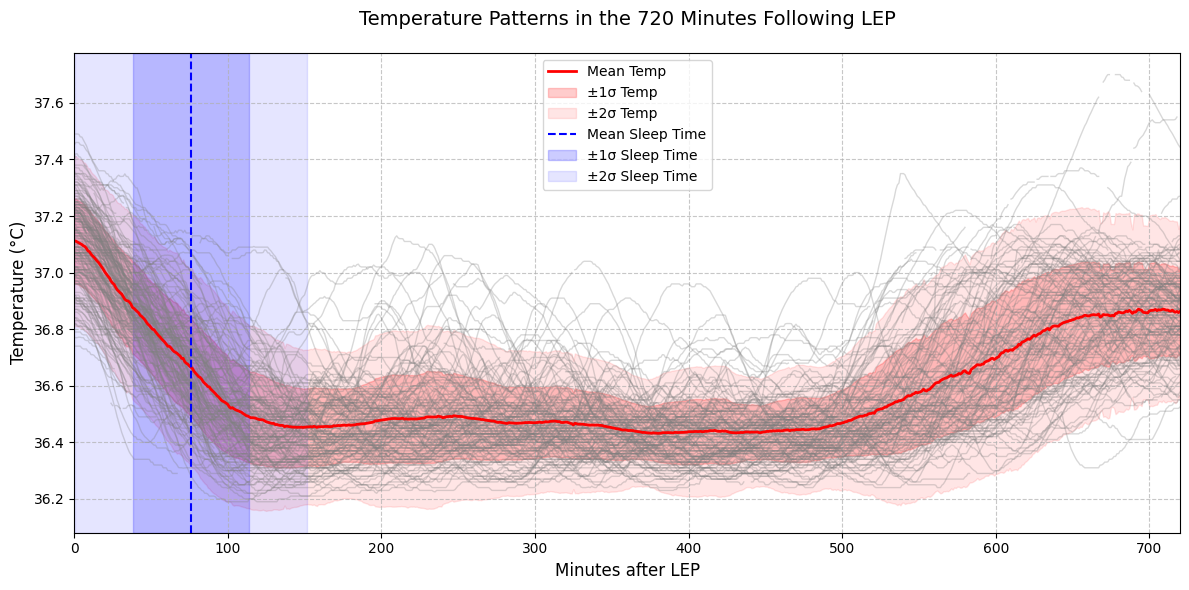

In [408]:

import matplotlib as plt
import circadian
reload(circadian)


first_day = all_processed.keys  
all_days = [d.strftime('%Y-%m-%d') for d in pd.date_range(first_day_with_data, today)]
last_3_months = [   ]


fig = circadian.plot_post_lep_periods_matplotlib(all_processed, merge_all_types(), 12 * 60)

Sleep mean as mins past LEP: 85.2 minutes +/- 28.8 minutes (= 68% of values are between 56.5 and 114.0 minutes after LEP)


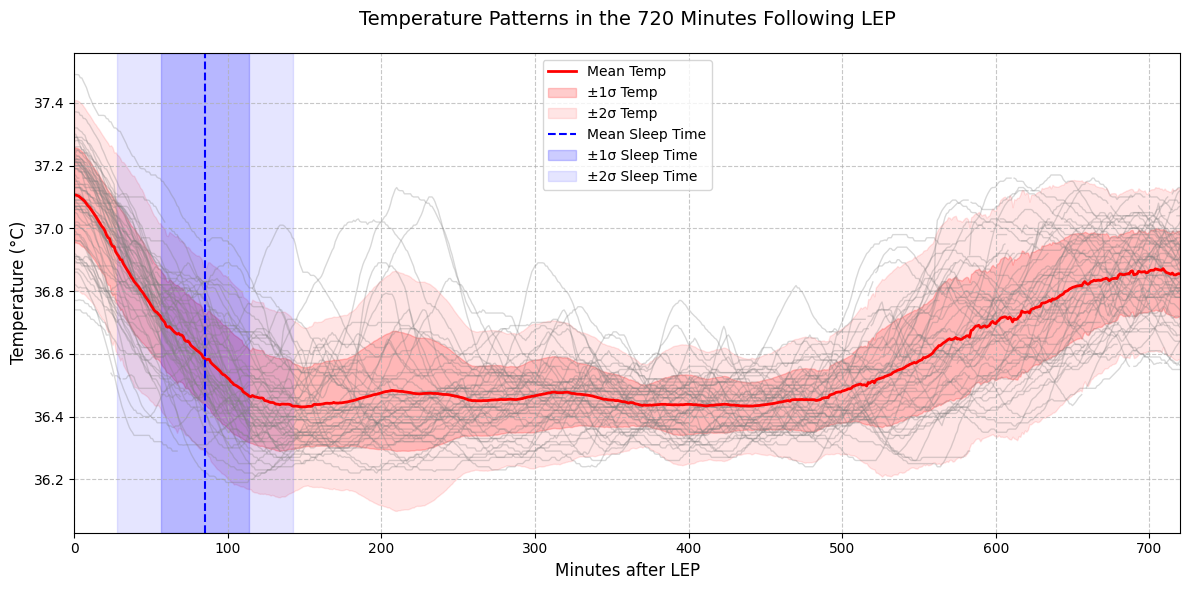

In [413]:
fig = circadian.plot_post_lep_periods_matplotlib(all_processed_last_3_months, merge_all_types(), 12 * 60)

Next

* Detect amount of time above and below mean, and how much.
* Look at steep and slow descenders.
* Look at those that don't descend cleanly.
* Do any of these correlate to e.g. more or stronger deep sleep? 

In [414]:
# import circadian
# reload(circadian)

# # Create list to store results
# all_nights_analysis = []

# m = merge_all_types()
# # Analyze each night
# for day in all_processed.keys():
#     metrics = circadian.compare_night_to_average(all_processed, m, post_lep_stats, day)
#     if metrics is not None:
#         metrics['dayAndNightOf'] = day
#         all_nights_analysis.append(metrics)

# # Convert to DataFrame
# nights_df = pd.DataFrame(all_nights_analysis)

# # Reorder columns to put dayAndNightOf first
# cols = ['dayAndNightOf'] + [col for col in nights_df.columns if col != 'dayAndNightOf']
# nights_df = nights_df[cols]

# # Sort by date
# nights_df = nights_df.sort_values('dayAndNightOf')
# nights_df.head()

In [355]:
# Convert dayAndNightOf to string in both dataframes
nights_df['dayAndNightOf'] = nights_df['dayAndNightOf'].astype(str)
day_data['dayAndNightOf'] = day_data['dayAndNightOf'].astype(str)

# Merge the dataframes
merged_for_corr = pd.merge(nights_df, day_data, on='dayAndNightOf', how='inner')

# Get numeric columns from day_data
numeric_cols = day_data.select_dtypes(include=['int64', 'float64']).columns

timedelta_cols = merged_for_corr.select_dtypes(include=['timedelta64[ns]']).columns
for col in timedelta_cols:
    merged_for_corr[col] = merged_for_corr[col].dt.total_seconds() / 60  # Convert to minutes

# Calculate correlations with valid counts
correlations_below_mean = []
correlations_above_mean = []
for col in numeric_cols:
    # Count valid pairs (where both columns have non-null values)
    valid_count = merged_for_corr[['minutes_below_mean', col]].dropna().shape[0]
    
    if valid_count >= 10:  # Only calculate correlation if we have enough data
        correlation = merged_for_corr['minutes_below_mean'].corr(merged_for_corr[col])
        correlations_below_mean.append({
            'column': col,
            'correlation': correlation,
            'valid_count': valid_count
        })

    valid_count = merged_for_corr[['minutes_above_mean', col]].dropna().shape[0]
    
    if valid_count >= 10:  # Only calculate correlation if we have enough data
        correlation = merged_for_corr['minutes_above_mean'].corr(merged_for_corr[col])
        correlations_above_mean.append({
            'column': col,
            'correlation': correlation,
            'valid_count': valid_count
        })

# Convert to DataFrame and sort by absolute correlation
corr_below_mean_df = pd.DataFrame(correlations_below_mean)
corr_below_mean_df['abs_correlation'] = corr_below_mean_df['correlation'].abs()
corr_below_mean_df = corr_below_mean_df.sort_values('abs_correlation', ascending=False)
corr_below_mean_df = corr_below_mean_df.drop('abs_correlation', axis=1)


corr_above_mean_df = pd.DataFrame(correlations_above_mean)
corr_above_mean_df['abs_correlation'] = corr_above_mean_df['correlation'].abs()
corr_above_mean_df = corr_above_mean_df.sort_values('abs_correlation', ascending=False)
corr_above_mean_df = corr_above_mean_df.drop('abs_correlation', axis=1)


# Display top correlations
print("Top correlations with minutes_below_mean (minimum 10 valid pairs):")
display(corr_below_mean_df)
print("Top correlations with minutes_above_mean (minimum 10 valid pairs):")
display(corr_above_mean_df)

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf

Top correlations with minutes_below_mean (minimum 10 valid pairs):


c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\graha\.conda\envs\3.10-tf

,column,correlation,valid_count
726,coreBodyTemp:GotIntoBedToMiddleOfSleep:mean,-0.683344,131
1912,circadian:combined:entries:NL:minsSinceReadyToSleep:vsDayMinus1,0.679691,16
599,circadian:combined:entries:LEP:temp,-0.652946,152
1830,circadian:basic:entries:LT1:temp:vsDayMinus1,0.650014,16
729,coreBodyTemp:GotIntoBedToMiddleOfSleep:percentile90,-0.649875,131
...,...,...,...
1995,events:startingPaidWork:count,NaN,23
2025,events:luminette:count,NaN,24
2027,events:sexWithClimax:count,NaN,30
2028,events:sexWithoutClimax:count,NaN,30


Top correlations with minutes_above_mean (minimum 10 valid pairs):


,column,correlation,valid_count
580,circadian:basic:entries:LEP:temp,0.682553,162
599,circadian:combined:entries:LEP:temp,0.675557,152
1831,circadian:basic:entries:LT1:temp:onDayMinus1,0.674565,16
1956,circadian:combined:entries:MP1:minsSinceSunsetEnd:onDayMinus1,-0.654140,14
729,coreBodyTemp:GotIntoBedToMiddleOfSleep:percentile90,0.651422,131
...,...,...,...
1995,events:startingPaidWork:count,NaN,23
2025,events:luminette:count,NaN,24
2027,events:sexWithClimax:count,NaN,30
2028,events:sexWithoutClimax:count,NaN,30


In [356]:
from notebooks.Util.MlKeys import sleep_factors, potential_sleep_affectors

#cols_to_include = [c for c in corr_df['column'] if not (c.startswith('circadian') or c.startswith('coreBodyTemp'))]

#use = corr_below_mean_df[corr_below_mean_df['column'].isin(potential_sleep_affectors)]

use = corr_above_mean_df[corr_above_mean_df['column'].isin(sleep_factors)]
df = use[use['correlation'].abs() > 0.1]
df

,column,correlation,valid_count
822,coreBodyTemp:AsleepToAwake:percentile90,0.424067,146
819,coreBodyTemp:AsleepToAwake:mean,0.418171,146
846,o2:AsleepToAwake:percentile90,0.363233,71
821,coreBodyTemp:AsleepToAwake:percentile10,0.339696,146
1725,night:aggregated:microwakingsWithinRemPerHour,0.241435,102
1724,night:aggregated:microwakingsPerHour,0.232130,102
908,night:yasa:adjusted:wakingsWithDurationCount,0.225027,102
2012,movement:AsleepToAwake:mean,0.221043,31
843,o2:AsleepToAwake:mean,0.183301,71
1152,night:yasaExtended:N3:alphaabs:mean,-0.175712,100


In [357]:
import altair as alt


col = "night:yasaExtended:N3:alphaabs:mean"
against = "minutes_above_mean"



plot_df = pd.DataFrame({
    'dayAndNightOf': merged_for_corr['dayAndNightOf'],
    'x': merged_for_corr[col],
    'y': merged_for_corr[against]
}).dropna()  # Remove any rows with missing values

# Calculate correlation
correlation = plot_df['x'].corr(plot_df['y'])

# Create scatter plot with trend line
scatter = alt.Chart(plot_df).mark_circle().encode(
    x=alt.X('x:Q', 
            title=col,
            scale=alt.Scale(zero=False)),
    y=alt.Y('y:Q', 
            title=against,
            scale=alt.Scale(zero=False)),
    tooltip=['dayAndNightOf', 
            alt.Tooltip('x:Q', format='.2f'),
            alt.Tooltip('y:Q', format='.2f')]
)

# Add trend line
trend_line = scatter.transform_regression('x', 'y').mark_line(
    color='red',
    strokeDash=[8, 4]
)

# Combine scatter and trend line
chart = (scatter + trend_line).properties(
    width=600,
    height=400,
    title=f'{against} vs {col} (r={correlation:.3f})'
)

# Display correlation and the chart
print(f"Correlation: {correlation:.3f}")
display(plot_df.head())
chart

Correlation: -0.176


,dayAndNightOf,x,y
0,2024-07-14,0.010920,0
1,2024-07-15,0.009116,61
2,2024-07-16,0.014069,60
3,2024-07-17,0.009807,0
4,2024-07-21,0.010989,0


alt.LayerChart(...)

# Detecting MP1

In [358]:
import circadian
reload(circadian)

# Merge MP1 and MP2, taking the latest, and calling that MP1.  It's unclear enough trying to pick them out without differentiating.

import circadian
reload(circadian)

cr, cr_df = circadian.get_circadian_reviews()

cr_known_mp1 = circadian.cr_known(cr_df, 'MP1')
cr_known_mp2 = circadian.cr_known(cr_df, 'MP2')

mp1_df = cr_known_mp1.rename(columns={
    'MP1_cr_datetime': 'MP_cr_datetime',
    'MP1_cr_temp': 'MP_cr_temp',
    'MP1_cr_prominence': 'MP_cr_prominence'
})
mp2_df = cr_known_mp2.rename(columns={
    'MP2_cr_datetime': 'MP_cr_datetime',
    'MP2_cr_temp': 'MP_cr_temp',
    'MP2_cr_prominence': 'MP_cr_prominence'
})

# Combine and sort by date and time
combined = pd.concat([mp1_df, mp2_df])
combined = combined.sort_values(['dayAndNightOf', 'MP_cr_datetime'])

# Keep the last entry for each day
merged = combined.groupby('dayAndNightOf').last().reset_index()

cr_known_mp1 = merged[['dayAndNightOf', 'MP_cr_datetime', 'MP_cr_temp', 'MP_cr_prominence']]
cr_known_mp1.head()

Getting circadian rhythm reviews
Starting to process circadian rhythm reviews


,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence
0,2024-07-15,2024-07-15 10:50:00+01:00,36.73,0.08
1,2024-07-16,2024-07-16 10:28:00+01:00,36.93,0.15
2,2024-07-22,2024-07-22 10:04:00+01:00,36.84,0.22
3,2024-07-23,2024-07-23 10:26:00+01:00,37.10,0.48
4,2024-07-24,2024-07-24 09:04:00+01:00,37.01,0.59


In [359]:
import circadian
reload(circadian)

# Test
mp1_det_df = circadian.extract_mp1(all_processed)
mp1_det_df.head()


,dayAndNightOf,MP_det_status,MP_det_reason,MP_det_time,MP_det_temp
0,2024-07-14,Not found,No relevant peaks found,NaT,NaN
1,2024-07-15,Detected,"Selected first stable peak at 10:47 from ['07:41', '10:47']",2024-07-15 10:47:00+01:00,36.735
2,2024-07-16,Not found,No relevant peaks found,NaT,NaN
3,2024-07-17,Detected,Selected first stable peak at 08:29 from ['08:29'],2024-07-17 08:29:00+01:00,36.530
4,2024-07-18,Detected,Selected first stable peak at 07:52 from ['07:52'],2024-07-18 07:52:00+01:00,36.520


In [360]:
import circadian
reload(circadian)

merged = merge_all_types()
joined_mp1_df, does_not_match_cr_mp1 = circadian.detect_mp1(all_processed, cr_known_mp1, merged)

display(joined_mp1_df['MP_diff'].describe())
display(len(does_not_match_cr_mp1))
display(circadian.display_stats(joined_mp1_df, does_not_match_cr_mp1, 'MP'))

does_not_match_cr_mp1.head(20)

count                          129
mean     0 days 00:11:53.488372093
std      0 days 00:41:39.056275365
min                0 days 00:00:00
25%                0 days 00:01:00
50%                0 days 00:01:00
75%                0 days 00:03:00
max                0 days 04:27:00
Name: MP_diff, dtype: object

14

,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence,MP_det_status,MP_det_reason,MP_det_time,MP_det_temp,MP_diff
160,2024-12-21,2024-12-21 11:42:00+00:00,36.95,0.52,Detected,"Selected first stable peak at 07:15 from ['07:15', '08:21']",2024-12-21 07:15:00+00:00,36.510000,0 days 04:27:00
19,2024-08-02,2024-08-02 10:28:00+01:00,37.10,NaN,Detected,Selected first stable peak at 06:33 from ['06:33'],2024-08-02 06:33:00+01:00,36.370000,0 days 03:55:00
245,2025-03-16,2025-03-16 07:42:00+00:00,36.93,0.38,Detected,"Selected first stable peak at 10:59 from ['07:41', '10:59']",2025-03-16 10:59:00+00:00,37.122727,0 days 03:17:00
238,2025-03-09,2025-03-09 09:52:00+00:00,37.05,0.31,Detected,Selected first stable peak at 07:02 from ['07:02'],2025-03-09 07:02:00+00:00,36.655652,0 days 02:50:00
91,2024-10-13,2024-10-13 09:20:00+01:00,37.27,0.28,Detected,Selected first stable peak at 06:38 from ['06:38'],2024-10-13 06:38:00+01:00,36.690000,0 days 02:42:00
194,2025-01-24,2025-01-24 11:08:00+00:00,37.27,0.23,Detected,Selected first stable peak at 09:35 from ['09:35'],2025-01-24 09:35:00+00:00,37.120000,0 days 01:33:00
127,2024-11-18,2024-11-18 08:26:00+00:00,37.13,0.37,Detected,Selected first stable peak at 07:20 from ['07:20'],2024-11-18 07:20:00+00:00,36.680000,0 days 01:06:00
246,2025-03-17,2025-03-17 08:54:00+00:00,37.09,0.15,Detected,"Selected first stable peak at 09:49 from ['07:37', '09:49']",2025-03-17 09:49:00+00:00,37.000000,0 days 00:55:00
149,2024-12-10,2024-12-10 09:28:00+00:00,37.00,0.62,Detected,"Selected first stable peak at 08:44 from ['06:57', '08:44', '09:27']",2024-12-10 08:44:00+00:00,36.980000,0 days 00:44:00
114,2024-11-05,2024-11-05 08:52:00+00:00,37.09,0.27,Detected,Selected first stable peak at 08:22 from ['08:22'],2024-11-05 08:22:00+00:00,37.092353,0 days 00:30:00


In [361]:
days_that_do_not_really_have_a_clear_mp1 = ['2024-07-15', '2024-08-09']
unusual_days_where_can_see_why_algo_gets_it_wrong_and_dont_mind_manually_tagging_it = [
    # Mahusive spike later than we expect
    '2024-07-28'
    ]

In [362]:
import circadian
reload(circadian)

do_it_all('2024-07-29', '04:00:00Z', '00:00:00Z')

c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'examined-life.co.uk'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


alt.VConcatChart(...)

'Comparing to average period after LEP'

None

In [363]:
joined_mp1_df

,dayAndNightOf,MP_cr_datetime,MP_cr_temp,MP_cr_prominence,MP_det_status,MP_det_reason,MP_det_time,MP_det_temp,MP_diff
0,2024-07-14,NaT,NaN,NaN,Not found,No relevant peaks found,NaT,NaN,NaT
1,2024-07-15,2024-07-15 10:50:00+01:00,36.73,0.08,Detected,"Selected first stable peak at 10:47 from ['07:41', '10:47']",2024-07-15 10:47:00+01:00,36.735000,0 days 00:03:00
2,2024-07-16,2024-07-16 10:28:00+01:00,36.93,0.15,Not found,No relevant peaks found,NaT,NaN,NaT
3,2024-07-17,NaT,NaN,NaN,Detected,Selected first stable peak at 08:29 from ['08:29'],2024-07-17 08:29:00+01:00,36.530000,NaT
4,2024-07-18,NaT,NaN,NaN,Detected,Selected first stable peak at 07:52 from ['07:52'],2024-07-18 07:52:00+01:00,36.520000,NaT
...,...,...,...,...,...,...,...,...,...
252,2025-03-23,NaT,NaN,NaN,Detected,Selected first stable peak at 07:36 from ['07:36'],2025-03-23 07:36:00+00:00,36.730000,NaT
253,2025-03-24,2025-03-24 08:32:00+00:00,37.02,0.35,Detected,Selected first stable peak at 08:35 from ['08:35'],2025-03-24 08:35:00+00:00,37.021957,0 days 00:03:00
254,2025-03-25,2025-03-25 08:02:00+00:00,37.01,0.41,Error,positional indexers are out-of-bounds,NaT,NaN,NaT
255,2025-03-26,2025-03-26 08:16:00+00:00,37.17,0.62,NaN,NaN,NaT,NaN,NaT


# Look for patterns between MP and LEP

In [455]:
import circadian
reload(circadian)

circadian.draw_mp_to_lep_2(merge_all_types())

Average Morning Peak: 8:46 ± 0.94h
Average Late Evening Peak: 21:51 ± 0.52h
Average time difference: 13.08 hours


alt.LayerChart(...)

In [454]:
import circadian
reload(circadian)

circadian.draw_mp_to_lep(merge_all_types())

Mean time from MP to LEP: 13.15 hours
Standard deviation: 0.94 hours


alt.LayerChart(...)

In [367]:
useful = m[['dayAndNightOf', 'MP_cr_datetime', 'LEP_cr_datetime', 'MP_To_LEP']]
mean = useful['MP_To_LEP'].mean()
std = useful['MP_To_LEP'].std()
short = useful[useful['MP_To_LEP'] < (mean - std)]
short

,dayAndNightOf,MP_cr_datetime,LEP_cr_datetime,MP_To_LEP
27,2024-08-10,2024-08-10 10:22:00+01:00,2024-08-10 22:02:00+01:00,0 days 11:40:00
100,2024-10-22,2024-10-22 08:38:00+01:00,2024-10-22 20:36:00+01:00,0 days 11:58:00
120,2024-11-11,2024-11-11 09:54:00+00:00,2024-11-11 22:06:00+00:00,0 days 12:12:00
133,2024-11-24,2024-11-24 10:02:00+00:00,2024-11-24 21:30:00+00:00,0 days 11:28:00
146,2024-12-07,2024-12-07 09:32:00+00:00,2024-12-07 21:40:00+00:00,0 days 12:08:00
160,2024-12-21,2024-12-21 11:42:00+00:00,2024-12-21 22:32:00+00:00,0 days 10:50:00
161,2024-12-22,2024-12-22 09:56:00+00:00,2024-12-22 22:00:00+00:00,0 days 12:04:00
168,2024-12-29,2024-12-29 09:38:00+00:00,2024-12-29 21:38:00+00:00,0 days 12:00:00
172,2025-01-02,2025-01-02 09:38:00+00:00,2025-01-02 21:44:00+00:00,0 days 12:06:00
201,2025-01-31,2025-01-31 09:28:00+00:00,2025-01-31 21:36:00+00:00,0 days 12:08:00


In [370]:
#do_it_all('2025-02-06', '06:00:00Z', '00:00:00Z')

Need to handle missing data days (2025-03-15)
And not present (2025-03-13)

# Looking at N hours before MP 

Wake mean as mins before MP: 86.5 minutes +/- 17.6 minutes (= 68% of values are between 68.9 and 104.1 minutes before MP)


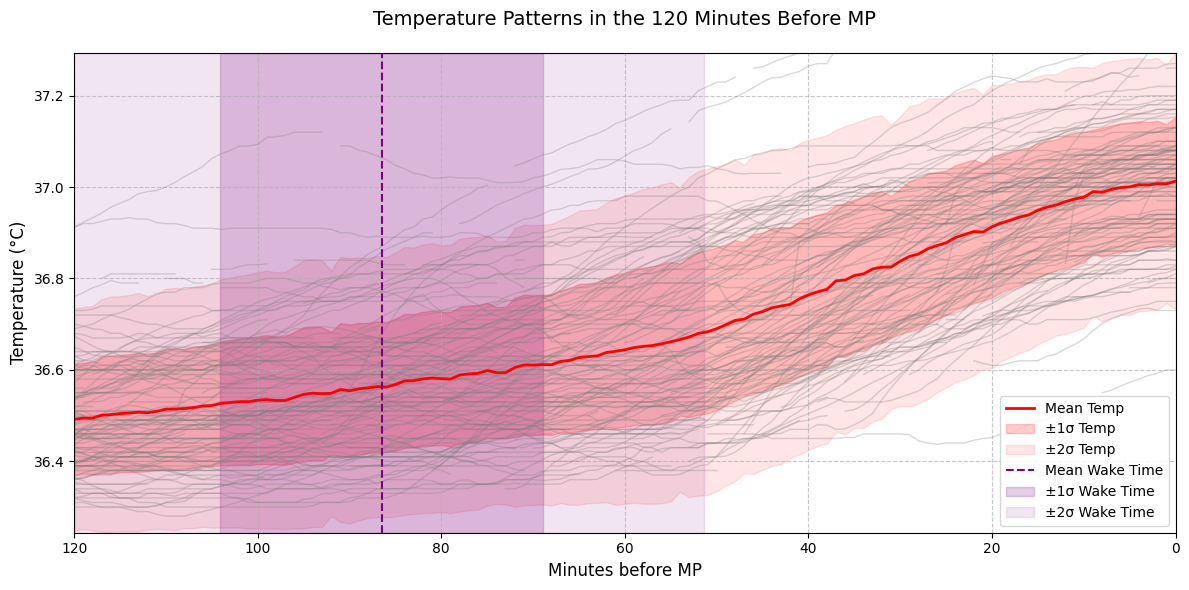

In [437]:

import circadian
reload(circadian)

fig = circadian.plot_pre_mp_periods_matplotlib(all_processed_no_insomniac_nights, merge_all_types(), 2 * 60)

# Looking at LEP through to MP and highlighting some days

In [486]:
import circadian
reload(circadian)

#test
day = '2024-09-09'
circadian.prepare_pre_mp_data(all_processed, merge_all_types(), all_processed[day], day, True)

No LEP time found for day 2024-09-09


In [398]:
debug_day('2024-11-05')

Wake time found for day 2024-10-11: 2024-10-12 09:03:00+01:00
CR data for day 2024-10-11:


,day_index,dayAndNightOf,MP1_status,MP2_status,EEP_status,MEP_status,MEP_temp,MEP_prominence,MEP_datetime,AP_status,...,MONP1_datetime,MONP2_temp,MONP2_prominence,MONP2_datetime,NL_temp,NL_prominence,NL_datetime,MP1_temp,MP1_prominence,MP1_datetime
89,89,2024-10-11,Missing data,NaN,NaN,NaN,NaN,NaN,NaT,Missing data,...,NaT,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT


LEP time found for day 2024-10-11: 2024-10-11 21:50:00+01:00


Sleep mean as mins past LEP: 76.3 minutes +/- 39.8 minutes (= 68% of values are between 36.5 and 116.2 minutes after LEP)
Wake mean as mins past LEP: 531.1 minutes +/- 63.0 minutes (= 68% of values are between 468.1 and 594.0 minutes after LEP)


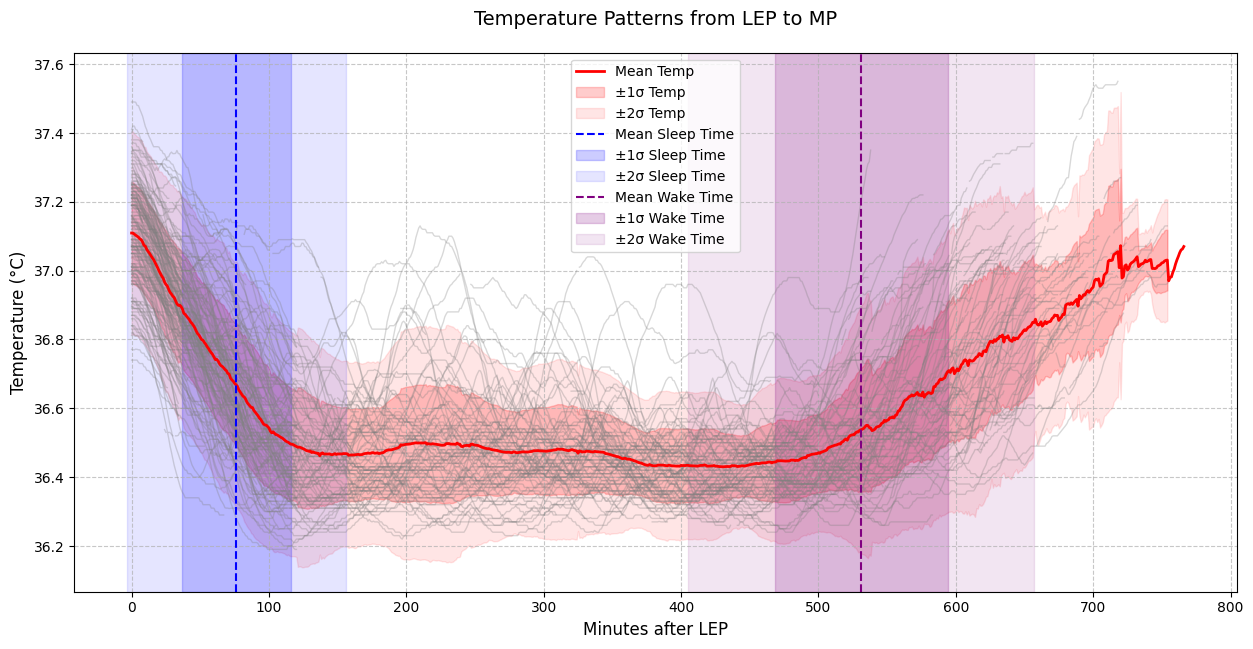

In [485]:
import circadian
reload(circadian)

fig = circadian.plot_lep_to_mp_period(all_processed, merge_all_types(), highlight_days=['2024-09-09'])
# fig = circadian.plot_lep_to_mp_period(all_processed, merge_all_types())

In [459]:
debug_day('2024-11-05')

df has 2161 rows of temp data
              Temp  Temp_Interpolated  Temp_Smoothed_Savgol
count  1017.000000        1066.000000           1009.000000
mean     36.657309          36.663424             36.654514
std       0.269836           0.267095              0.268965
min      36.270000          36.270000             36.272796
25%      36.350000          36.359413             36.351886
50%      36.700000          36.700000             36.693912
75%      36.890000          36.890000             36.889791
max      37.150000          37.150000             37.151500
Wake time found for day 2024-11-05: 2024-11-06 02:37:00+00:00
No sleep time found for day 2024-11-05
CR data for day 2024-11-05:


,day_index,dayAndNightOf,MP1_status,MP2_status,EEP_status,MEP_status,MEP_temp,MEP_prominence,MEP_datetime,AP_status,...,MONP1_datetime,MONP2_temp,MONP2_prominence,MONP2_datetime,NL_temp,NL_prominence,NL_datetime,MP1_temp,MP1_prominence,MP1_datetime
114,114,2024-11-05,Selected,NaN,NaN,NaN,NaN,NaN,NaT,Missing data,...,NaT,NaN,NaN,NaT,NaN,NaN,NaT,37.09,0.27,2024-11-05 08:52:00+00:00


LEP time found for day 2024-11-05: 2024-11-05 21:42:00+00:00


# TODO: What is a desirable circadian rhythm?

What factors can I compare to:
* Length of sleep.

Is a long gap between MP and LEP good?  (Bearing in mind that means the overnight gap between LEP and the next day's MP will be reduced).  Or should it be a steady 12 hours?

Should the temp range be strong?

Should prominence of LEP and MP be high?


# TODO What controls CR?
Does morning light (intensity?), luminettes, adjust LEP (time, prominence, temp?)

Can showers help set LEP?

# TODO: Look at peaks during night

# Finding days where I'm falling asleep or waking later/earlier than usual


In [500]:
# Test
import circadian
reload(circadian)

day = '2025-03-20'
circadian.analyze_sleep_wake_timing_for_day(all_processed_no_insomniac_nights, merge_all_types(), all_processed[day], day, True)

Wake time: 2025-03-21 06:01:09+00:00, LEP time: 2025-03-20 21:22:00+00:00, Minutes after LEP: 519.15


{'date': '2025-03-20',
 'sleep_mins_after_lep': 69.65,
 'wake_mins_after_lep': 519.15,
 'sleep_time': '22:31',
 'wake_time': '06:01',
 'lep_time': '21:22'}

In [513]:
import circadian
reload(circadian)

timing_df = circadian.analyze_sleep_wake_timing(all_processed_no_insomniac_nights, merge_all_types())
timing_df.head()

,date,sleep_mins_after_lep,wake_mins_after_lep,sleep_time,wake_time,lep_time,sleep_mins_after_lep_vs_mean,wake_mins_after_lep_vs_mean,time_would_expect_to_sleep,time_would_expect_to_wake
0,2024-07-17,-2.0,445.0,23:26,06:53,23:28,-78.3,-86.1,00:44,08:19
1,2024-07-21,64.0,476.0,23:44,06:36,22:40,-12.3,-55.1,23:56,07:31
2,2024-07-22,48.5,470.0,23:30,06:32,22:42,-27.8,-61.1,23:58,07:33
3,2024-07-24,52.0,503.0,23:44,07:15,22:52,-24.3,-28.1,00:08,07:43
4,2024-07-28,73.5,518.0,23:39,07:04,22:26,-2.8,-13.1,23:42,07:17


In [489]:
debug_day(day)

df has 2161 rows of temp data
              Temp  Temp_Interpolated  Temp_Smoothed_Savgol
count  1418.000000        1490.000000           1461.000000
mean     36.745759          36.744372             36.747560
std       0.209162           0.207979              0.208370
min      36.230000          36.230000             36.230452
25%      36.597927          36.590000             36.597626
50%      36.830000          36.820000             36.832085
75%      36.891315          36.890000             36.894348
max      37.140000          37.140000             37.141746
Wake time found for day 2024-09-09: 2024-09-10 08:29:30+01:00
Sleep time found for day 2024-09-09: 2024-09-09 22:37:00+01:00
CR data for day 2024-09-09:


,day_index,dayAndNightOf,MP1_status,MP2_status,EEP_status,MEP_status,MEP_temp,MEP_prominence,MEP_datetime,AP_status,...,MONP1_datetime,MONP2_temp,MONP2_prominence,MONP2_datetime,NL_temp,NL_prominence,NL_datetime,MP1_temp,MP1_prominence,MP1_datetime
57,57,2024-09-09,Selected,NaN,NaN,NaN,NaN,NaN,NaT,Not present,...,NaT,NaN,NaN,NaT,NaN,NaN,NaT,37.14,0.74,2024-09-09 07:54:00+00:00


No merged data for day 2024-09-09


# LEP stability

In [520]:
import circadian
reload(circadian)

circadian.draw_lep_stability(merge_all_types(exclude_insomniac_nights=False))

Average LEP: 21:50
Overall Standard Deviation: 0.51h


alt.LayerChart(...)

# MP stability

In [522]:
import circadian
reload(circadian)

circadian.draw_mp_stability(merge_all_types(exclude_insomniac_nights=True))

Average MP: 8:46
Overall Standard Deviation: 0.94h


alt.LayerChart(...)

# Creating merged data

In [515]:
timing_df

,date,sleep_mins_after_lep,wake_mins_after_lep,sleep_time,wake_time,lep_time,sleep_mins_after_lep_vs_mean,wake_mins_after_lep_vs_mean,time_would_expect_to_sleep,time_would_expect_to_wake
0,2024-07-17,-2.0,445.0,23:26,06:53,23:28,-78.3,-86.1,00:44,08:19
1,2024-07-21,64.0,476.0,23:44,06:36,22:40,-12.3,-55.1,23:56,07:31
2,2024-07-22,48.5,470.0,23:30,06:32,22:42,-27.8,-61.1,23:58,07:33
3,2024-07-24,52.0,503.0,23:44,07:15,22:52,-24.3,-28.1,00:08,07:43
4,2024-07-28,73.5,518.0,23:39,07:04,22:26,-2.8,-13.1,23:42,07:17
...,...,...,...,...,...,...,...,...,...,...
130,2025-03-14,55.5,511.5,22:39,06:15,21:44,-20.8,-19.6,23:00,06:35
131,2025-03-15,-3.0,509.5,22:11,06:43,22:14,-79.3,-21.6,23:30,07:05
132,2025-03-16,104.0,609.0,22:16,06:41,20:32,27.7,77.9,21:48,05:23
133,2025-03-18,58.5,532.5,22:36,06:30,21:38,-17.9,1.4,22:54,06:29


# Getting most useful CR setters

In [609]:
[c for c in day_data.columns if 'dayminus1' in c.lower() and 'lep' in c.lower() ]

['circadian:basic:entries:LEP:temp:vsDayMinus1',
 'circadian:basic:entries:LEP:temp:onDayMinus1',
 'circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1',
 'circadian:basic:entries:LEP:datetimeSSM:onDayMinus1',
 'circadian:basic:entries:LEP:prominence:vsDayMinus1',
 'circadian:basic:entries:LEP:prominence:onDayMinus1',
 'circadian:combined:entries:LEP:temp:vsDayMinus1',
 'circadian:combined:entries:LEP:temp:onDayMinus1',
 'circadian:combined:entries:LEP:datetimeSSM:vsDayMinus1',
 'circadian:combined:entries:LEP:datetimeSSM:onDayMinus1',
 'circadian:combined:entries:LEP:prominence:vsDayMinus1',
 'circadian:combined:entries:LEP:prominence:onDayMinus1',
 'circadian:combined:entries:LEP:minsSinceReadyToSleep:vsDayMinus1',
 'circadian:combined:entries:LEP:minsSinceReadyToSleep:onDayMinus1',
 'circadian:combined:entries:LEP:minsUntilWake:vsDayMinus1',
 'circadian:combined:entries:LEP:minsUntilWake:onDayMinus1',
 'circadian:combined:entries:LEP:minsSinceSleep:vsDayMinus1',
 'circadian:combined

In [621]:
most_useful = [
    'sunrise:sunriseBeginSSM',
 'sunrise:sunriseEndSSM',
 'sunrise:sunsetBeginSSM',
 'sunrise:sunsetEndSSM',
 'sunrise:solarNoonSSM',
 'sunrise:dayLengthSecs',
 'sunrise:sunriseDurationSecs',
 'sunrise:sunsetDurationSecs',
 'sunExposure:totalTimeOutsideSecs',
 'sunExposure:totalTimeAnySunSecs',
 'sunExposure:firstEnteredOutsideSSM',
 'sunExposure:firstDurationOutsideSecs',
 'sunExposure:lastOutsideSSM',
 # Missing some values but during a period we can interpolate easily
 'sunExposure:lightDuringFirstTimeOutside',
 'sunExposureCombined:betweenWakeAndFirstSunSecs',
 'events:shower:count', 

 'circadian:basic:entries:LEP:datetimeSSM',
 'circadian:basic:entries:MP1:datetimeSSM',
 'circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1'

 # Tricky
#  'events:shower:firstSSM', 'events:shower:lastSSM',
#  'events:rgm:count', 'events:rgm:firstSSM', 'events:rgm:lastSSM',
#  'events:sex:count',
#  'events:sex:firstSSM',
#  'events:sex:lastSSM',
]

def analyze_missing_values(day_data, columns):
    """
    Analyze missing values for specific columns in day_data, using dayAndNightOf for dates.
    
    Args:
        day_data: DataFrame containing the data
        columns: List of column names to analyze
    """
    # Check which columns exist in the dataframe
    existing_cols = [col for col in columns if col in day_data.columns]
    missing_cols = [col for col in columns if col not in day_data.columns]
    
    if missing_cols:
        print("Columns not found in dataframe:")
        for col in missing_cols:
            print(f"  - {col}")
        print()
    
    # Analyze missing values for existing columns
    missing_stats = day_data[existing_cols].isnull().sum()
    missing_pct = (day_data[existing_cols].isnull().sum() / len(day_data)) * 100
    
    # Get first and last dates with missing values for each column
    first_missing = {}
    last_missing = {}
    
    for col in existing_cols:
        missing_dates = day_data[day_data[col].isnull()]['dayAndNightOf']
        if len(missing_dates) > 0:
            first_missing[col] = missing_dates.min()
            last_missing[col] = missing_dates.max()
        else:
            first_missing[col] = None
            last_missing[col] = None
    
    # Create summary DataFrame
    summary = pd.DataFrame({
        'Missing Count': missing_stats,
        'Missing %': missing_pct.round(1),
        'First Missing': pd.Series(first_missing),
        'Last Missing': pd.Series(last_missing)
    }).sort_values('Missing Count', ascending=False)
    
    # Only show columns with missing values
    summary_with_missing = summary[summary['Missing Count'] > 0]
    
    # if len(summary_with_missing) > 0:
    #     print("Columns with missing values:")
    #     print(summary_with_missing)
    # else:
    #     print("No missing values found in the specified columns!")
    
    # # Print total date range of data for context
    # print("\nTotal date range in dataset:")
    # print(f"First date: {day_data['dayAndNightOf'].min()}")
    # print(f"Last date:  {day_data['dayAndNightOf'].max()}")
    
    return summary

summary = analyze_missing_values(day_data, most_useful)
summary

,Missing Count,Missing %,First Missing,Last Missing
circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1,260,76.0,2024-04-21,2025-03-26
circadian:basic:entries:MP1:datetimeSSM,210,61.4,2024-04-21,2025-03-27
sunExposure:lightDuringFirstTimeOutside,176,51.5,2024-04-21,2025-03-28
circadian:basic:entries:LEP:datetimeSSM,173,50.6,2024-04-21,2025-03-22
sunExposureCombined:betweenWakeAndFirstSunSecs,123,36.0,2024-04-21,2025-03-28
events:shower:count,115,33.6,2024-04-21,2024-08-13
sunExposure:firstEnteredOutsideSSM,111,32.5,2024-04-21,2025-03-22
sunExposure:lastOutsideSSM,111,32.5,2024-04-21,2025-03-22
sunExposure:firstDurationOutsideSecs,111,32.5,2024-04-21,2025-03-22
sunExposure:totalTimeAnySunSecs,15,4.4,2024-04-21,2024-05-05


In [622]:

columns_to_select = most_useful.copy()  # Create a copy to avoid modifying the original
columns_to_select.append("dayAndNightOf")
columns_to_select
df = day_data[day_data['dayAndNightOf'] >= '2024-08-14'][columns_to_select]

# Missing because sometimes I didn't go outside
df["sunExposure:wentOutside"] = df["sunExposure:firstEnteredOutsideSSM"].notna().astype(int)
df["sunExposure:lastOutsideSSM"].fillna(0, inplace=True)
df["sunExposure:firstEnteredOutsideSSM"].fillna(0, inplace=True)
df["sunExposure:firstDurationOutsideSecs"].fillna(0, inplace=True)
df["sunExposure:lightDuringFirstTimeOutside"].fillna(0, inplace=True)

df["sunExposure:lightDuringFirstTimeOutside"] = df["sunExposure:lightDuringFirstTimeOutside"].fillna(
    df["sunExposure:lightDuringFirstTimeOutside"].shift().rolling(window=3, min_periods=1).mean()
)

# Missing because sometimes I didn't go outside and sometimes I don't have wake time times
df["sunExposureCombined:betweenWakeAndFirstSunSecs"].fillna(0, inplace=True)

day_data_scrubbed = df.copy()

analyze_missing_values(day_data_scrubbed, most_useful)

C:\Users\graha\AppData\Local\Temp\ipykernel_25224\914083903.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["sunExposure:lastOutsideSSM"].fillna(0, inplace=True)
C:\Users\graha\AppData\Local\Temp\ipykernel_25224\914083903.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

,Missing Count,Missing %,First Missing,Last Missing
circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1,155,68.3,2024-08-21,2025-03-26
circadian:basic:entries:MP1:datetimeSSM,104,45.8,2024-08-17,2025-03-27
circadian:basic:entries:LEP:datetimeSSM,73,32.2,2024-08-21,2025-03-22
sunExposure:firstEnteredOutsideSSM,0,0.0,None,None
events:shower:count,0,0.0,None,None
sunExposureCombined:betweenWakeAndFirstSunSecs,0,0.0,None,None
sunExposure:lightDuringFirstTimeOutside,0,0.0,None,None
sunExposure:lastOutsideSSM,0,0.0,None,None
sunExposure:firstDurationOutsideSecs,0,0.0,None,None
sunrise:sunriseBeginSSM,0,0.0,None,None


In [624]:
have_nan_values = ['circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1',
                   'circadian:basic:entries:MP1:datetimeSSM',
                   'circadian:basic:entries:LEP:datetimeSSM']

# Worth adding:
* Time outside before 12, 11, 10
* Time outside within N hours of sunrise
* Light during those periods

# Train model to predict LEP

In [ ]:
import circadian_models
reload(circadian_models)

merged_with_lep = day_data_scrubbed.copy().drop(columns='circadian:basic:entries:MP1:datetimeSSM')

models_and_data = circadian_models.create_and_add_all(merged_with_lep, False, "circadian:basic:entries:MP1:datetimeSSM")

from models.final_wake.final_wake_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(md: ModelAndData):
    X_train, X_val, y_train, y_val = train_test_split(md.X, md.y, test_size=0.1, random_state=42)

    md.X_train = X_train
    md.X_val = X_val
    md.y_train = y_train
    md.y_val = y_val

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

CleanTargetCol (227, 19) to (154, 19)
RequireNonEmptyRows: before 154 rows after 154 rows
DropBadRows: before 154 rows after 154 rows
Training set size circadian:basic:entries:MP1:datetimeSSM: 138, validation set size: 16


In [602]:
import models.util.importances
reload(models.util.importances)

import models.util.rfe_training as training
reload(training)
import copy
from models.util.rfe_training import train_rfe

import memory

memory.garbage_collect(print)

train_list = []
train_list.append({"type": "XGBoostRegressor", "rfe": False})

for md in models_and_data:
    for tl in train_list:
        md.models = train_rfe(training.get_model, tl, md.name, md.X_train, md.y_train, md.X_val, md.y_val, do_rfe=False)

import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)
pd.set_option('display.max_columns', None)

display(evaluation.evaluate_regression_models(models_and_data))
display(evaluation.evaluate_classification_models(models_and_data))

Memory Usage: 810.17 MB GC to 810.17 MB
Training XGBoostRegressor model for circadian:basic:entries:MP1:datetimeSSM with (138, 17)... RMSE train: 0.5116865534317492 RMSE val: 1570.6603273389007


,MAE_Train,MAE_Val,RMSE_Train,RMSE_Val,Rows_Train,Model,MdIdx,MsIdx,n_features,source,isClassifier
0,0.355865,1212.896484,0.511687,1570.660327,138,circadian:basic:entries:MP1:datetimeSSM,0,0,17,XGBoostRegressor,False


c:\dev\Brainwave-Processor\models\util\evaluation.py:266: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df = results_df.applymap(lambda x: str(x) if isinstance(x, float) else x)


""


In [604]:
bm = models_and_data[0].models[0]

In [605]:
import shap
import xgboost as xgb
explainer = shap.Explainer(bm.model)
shap_values = explainer(bm.X_train)

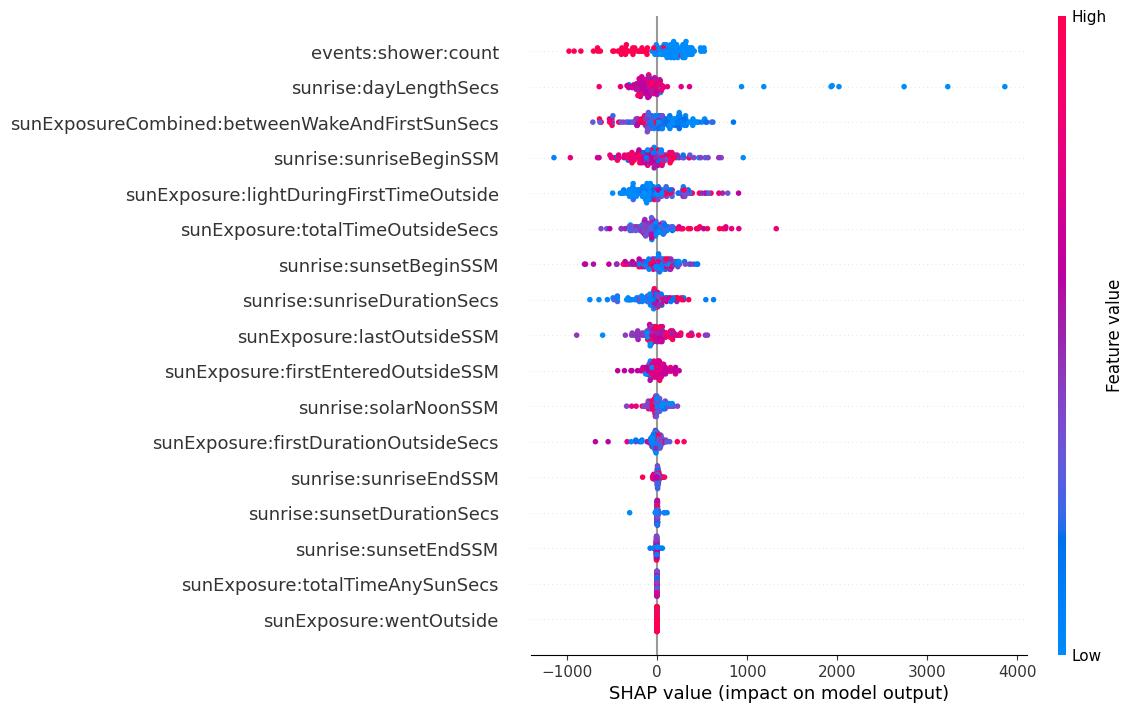

In [606]:
shap.plots.beeswarm(shap_values, max_display=20)


# Train a model to predict LEP stability

CleanTargetCol (227, 19) to (72, 19)
RequireNonEmptyRows: before 72 rows after 72 rows
DropBadRows: before 72 rows after 72 rows
Training set size circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1: 64, validation set size: 8
Training XGBoostRegressor model for circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1 with (64, 17)... RMSE train: 0.037325241036772254 RMSE val: 2876.321771744063


,MAE_Train,MAE_Val,RMSE_Train,RMSE_Val,Rows_Train,Model,MdIdx,MsIdx,n_features,source,isClassifier
0,0.017596,2439.214859,0.037325,2876.321772,64,circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1,0,0,17,XGBoostRegressor,False


c:\dev\Brainwave-Processor\models\util\evaluation.py:266: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  results_df = results_df.applymap(lambda x: str(x) if isinstance(x, float) else x)


""


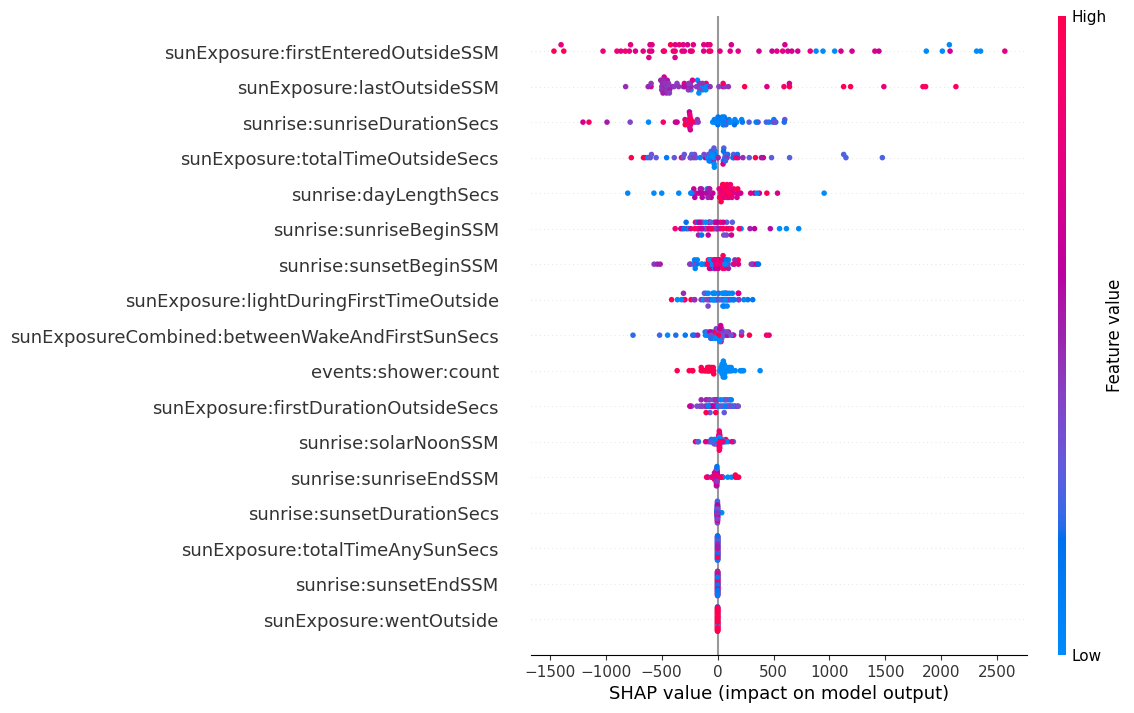

In [617]:
import circadian_models
reload(circadian_models)

target = 'circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1'
merged_with_target = day_data_scrubbed.copy()
target_df = day_data[['dayAndNightOf', target]].copy()#.drop(columns=['circadian:basic:entries:MP1:datetimeSSM'])
merged_with_target = pd.merge(
    merged_with_lep, 
    target_df,
    on='dayAndNightOf',
    how='left'  # Use left join to keep all rows in merged_with_lep
).drop(columns=['circadian:basic:entries:LEP:datetimeSSM'])

models_and_data = circadian_models.create_and_add_all(merged_with_target, False, target)

from models.final_wake.final_wake_model import ModelAndData
from sklearn.model_selection import train_test_split

def split(md: ModelAndData):
    X_train, X_val, y_train, y_val = train_test_split(md.X, md.y, test_size=0.1, random_state=42)

    md.X_train = X_train
    md.X_val = X_val
    md.y_train = y_train
    md.y_val = y_val

for md in models_and_data:
    split(md)
    print(f"Training set size {md.name}: {len(md.X_train)}, validation set size: {len(md.X_val)}")

import models.util.importances
reload(models.util.importances)

import models.util.rfe_training as training
reload(training)
from models.util.rfe_training import train_rfe

train_list = []
train_list.append({"type": "XGBoostRegressor", "rfe": False})

for md in models_and_data:
    for tl in train_list:
        md.models = train_rfe(training.get_model, tl, md.name, md.X_train, md.y_train, md.X_val, md.y_val, do_rfe=False)

import models.util.evaluation as evaluation
from importlib import reload
reload(evaluation)
pd.set_option('display.max_columns', None)

display(evaluation.evaluate_regression_models(models_and_data))
display(evaluation.evaluate_classification_models(models_and_data))

bm = models_and_data[0].models[0]

import shap
import xgboost as xgb
explainer = shap.Explainer(bm.model)
shap_values = explainer(bm.X_train)

shap.plots.beeswarm(shap_values, max_display=20)


# More analysis of scrubbed data

In [647]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

def multiple_regression(target1: str):
    df1 = day_data_scrubbed.copy()
    # df2 = day_data_scrubbed.copy()

    df1 = df1.drop(columns=[col for col in have_nan_values if col != target1])
    df1 = df1[~df1[target1].isna()]

    X = df1.copy().drop(columns=[target1, 'dayAndNightOf'])
    y1 = df1[target1]
    #y2 = day_data_scrubbed['circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1']

    # Fit regression models
    model1 = LinearRegression().fit(X, y1)
    # model2 = LinearRegression().fit(X, y2)

    # Compute R² scores
    r2_y1 = model1.score(X, y1)
    # r2_y2 = model2.score(X, y2)

    # R² (coefficient of determination) tells you the proportion of variance in the target explained by the predictors.
    # Closer to 1.0 means a strong explanation, while values near 0.0 mean weak explanation.
    print(f'R² for {target1} = {r2_y1:.4f}')
    # print(f'R² for LEP:datetimeSSM:vsDayMinus1 = {r2_y2:.4f}')

    # PCA/PLS can help reduce complexity and reveal which predictor combinations matter most.

    pls = PLSRegression(n_components=3)  # Adjust components as needed
    pls.fit(X, y1)
    y1_pred = pls.predict(X)
    r2_pls = r2_score(y1, y1_pred)

    # If PCA shows strong multicollinearity, PLS regression is better for understanding how predictor variables relate to the target variables.
    # This captures latent relationships between predictors and targets, even when predictors are highly correlated.
    print(f'PLS R² for {target1} = {r2_pls:.4f}')


multiple_regression('circadian:basic:entries:LEP:datetimeSSM')
multiple_regression('circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1')
multiple_regression('circadian:basic:entries:MP1:datetimeSSM')


R² for circadian:basic:entries:LEP:datetimeSSM = 0.1722
PLS R² for circadian:basic:entries:LEP:datetimeSSM = 0.1285
R² for circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1 = 0.2997
PLS R² for circadian:basic:entries:LEP:datetimeSSM:vsDayMinus1 = 0.1784
R² for circadian:basic:entries:MP1:datetimeSSM = 0.5331
PLS R² for circadian:basic:entries:MP1:datetimeSSM = 0.3997
